# IMDB-5000 Dataset Analysis - *Given information about a movie, predict whether it is terrible, bad, good or great.*

## How is this useful?

Developing an accurate model that can predict whether or not a movie would successful in the eyes of audiences would be quite useful for first time film makers who have no idea what kind of resources to invest in their movie. It would also be useful for production companies who want to maximise output of good movies. These kinds of people could take the model and input the resources that they have on hand and the model will tell them what kind of audience they can expect to some degree of accuracy. 

This could also be useful for predicting how good a movie that has not been released yet will be. One could use the model to predict how good an upcoming movie will be and do something with this information, such as bet on it.

## About the Dataset

The IMDB-5000 dataset is of size (5043,28), meaning we have 5043 observations (datapoints) and 28 features (variables). The variables are things like:

* Director name
* Duration
* Names of top 3 actors in the movie
* Language
* Budget
* Gross
* Number of Facebook likes for director and top 3 actors

## About this Notebook

This analysis is split into 4 parts:

### Part 1: Dataset Exploration
    1. Dealing with Missing Values
    2. Removing Highly Co-Correlated Features
### Part 2: Dataset Preprocessing
    1. Categorising the Dependent Variable
    2. Splitting the data into Independent & Dependent Variables
    3. Feature Scaling
    4. Train-Test Split
### Part 3: Model Training & Evaluation
    1. Naïve Bayes
    2. K-Nearest Neighbours
    3. Support Vector Machine
    4. Random Forest Classifier
    5. Ariticial Neural Network Classifier
    6. Model Comparison
### Part 4: Summary and Conclusions

## Part 1: Dataset Exploration

#### In this section we begin to sort through the data and examine the features. We will deal with missing values, remove highly correlated features and any other features that are not relevant or useful for the analysis.

### i) Dealing with Missing Values

First we print the shape of the dataset to understand how many variables we are working with. We print the colums to see what each variable is. We will apply some very basic manipulations to remove useless variables and rearrage the data.

Since the 'score' is the dependent variable, it is useful to move this column to the end of the dataset. We also remove the `imdb_movie_link` columns because it is not useful.

We need to know which columns contain `NaN` (missing) values as these need to be dealt with. We plot a bar chart displaying how many `NaN` values there are per column.

Dataset shape:  (5043, 28)
Dataset columns:  Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')
new shape:  (5043, 27)


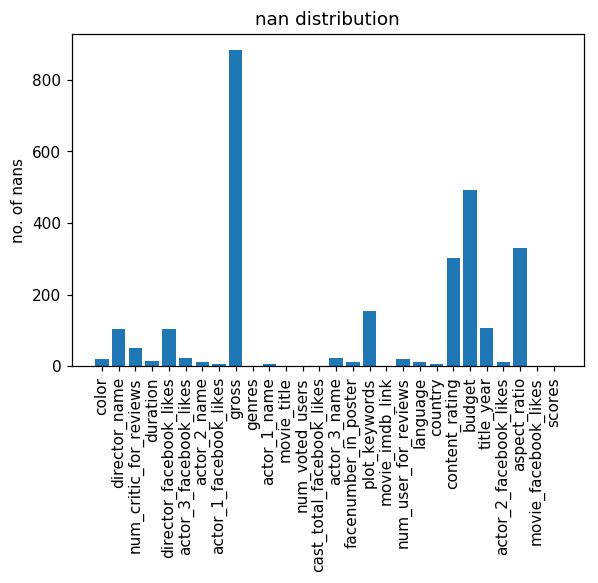

In [133]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
dataset = pd.read_csv('movie_metadata.csv')
print("Dataset shape: ", dataset.shape)
print("Dataset columns: ", dataset.columns)

# move the dependent variable to the end of the dataframe
scores = list(dataset.iloc[:, -3].values)
dataset = dataset.drop(columns='imdb_score')
dataset['scores'] = scores

# count number of NaN values in the columns
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns='movie_imdb_link')
# we remove all rows where there is no score
dataset = dataset.dropna(axis=0,subset=['scores'])
print("new shape: ", dataset.shape)


From this quick analysis we can see that gross has >10% of rows as NaN. We shall just remove this column instead of attempting to impute values. 

Some of these other columns with a large number of `NaN`s can be reasonably imputed, such as budget and aspect ratio. For the former we can set `NaN`s to the median of the column and for aspect ratio we can set `NaN`s to the most frequent value of the column.

For the rest of the colums, there are not many `NaNs` so we will simply delete these datapoints.

shape of data before:  (5043, 27)
shape of data after:  (4634, 16)


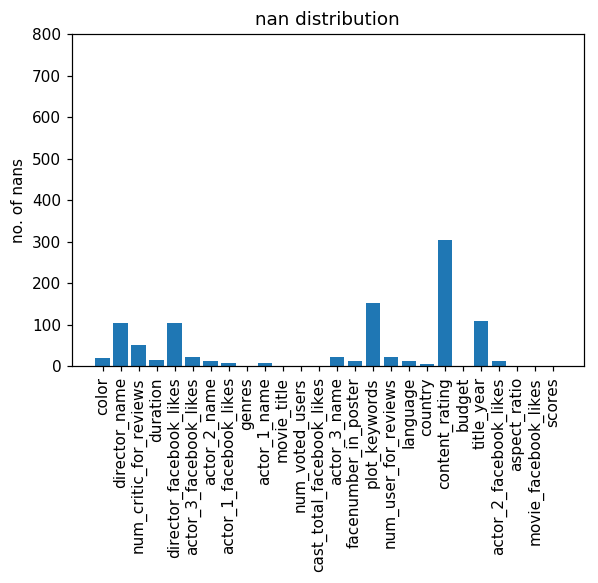

In [134]:
print("shape of data before: ", dataset.shape)

# Taking care of missing data
dataset = dataset.drop(columns='gross')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(np.asarray(dataset['budget']).reshape(-1,1))
dataset['budget'] = imputer.transform(np.asarray(dataset['budget']).reshape(-1,1))

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(np.asarray(dataset['aspect_ratio']).reshape(-1,1))
dataset['aspect_ratio'] = imputer.transform(np.asarray(dataset['aspect_ratio']).reshape(-1,1))

nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.ylim(0,800)
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns=['color','language','director_name','plot_keywords','genres','movie_title','actor_1_name','actor_2_name','actor_3_name','country'])

dataset = dataset.dropna(axis=0)
print("shape of data after: ", dataset.shape)

In [130]:
for i in range(dataset.select_dtypes(include='object').shape[1]):
    print(dataset.select_dtypes(include='object').columns[i], 
          pd.Series(dataset.select_dtypes(include='object').iloc[:,i].values).nunique(dropna=True))

content_rating 15


This results in a dataset with 4857 rows. This is pretty good since we originally had 1287 rows that contained at least one `NaN` value, meaning that if we decided to deal with `NaN`s by deleting these rows, we would end up with a dataset with only 3756 rows. Instead we have a dataset with 4857 rows; we have only deleted 186 observations.

### ii) Removing highly co-correlated features

Features that are highly co-correlated are redundant and are not useful, so we can remove them. For example, if you have 2 variables that are used to predict some output and the 2 variables are highly correlated, using both of them in the model is not necessary since they are very closely related.

We compute the correlation matrix for all of the variables and we will remove all variables that are correlated with correlation coefficient > 0.7.

In [131]:
from sklearn.feature_selection import VarianceThreshold

correlated_features = set()
correlation_matrix = dataset.corr()

print(correlation_matrix)

# remove correlated features
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(len(correlated_features))
print(correlated_features)

dataset.drop(labels=correlated_features, axis=1, inplace=True)
print(dataset.columns)

                           num_critic_for_reviews  duration  \
num_critic_for_reviews                   1.000000  0.244870   
duration                                 0.244870  1.000000   
director_facebook_likes                  0.176778  0.177184   
actor_3_facebook_likes                   0.264478  0.130861   
actor_1_facebook_likes                   0.193989  0.093101   
num_voted_users                          0.614874  0.341211   
cast_total_facebook_likes                0.264920  0.129525   
facenumber_in_poster                    -0.032901  0.022080   
num_user_for_reviews                     0.593984  0.353092   
budget                                   0.117039  0.072553   
title_year                               0.319192 -0.128118   
actor_2_facebook_likes                   0.273093  0.135355   
aspect_ratio                             0.072771  0.074429   
movie_facebook_likes                     0.690376  0.213654   
scores                                   0.342954  0.36

We find from this analysis that `num_user_for_reviews`, which is correlated with `num_voted_users` and `cast_total_facebook_likes`, which is highly correlated with `actor_1_facebook_likes`.

Therefore, we drop the `num_user_for_reviews` and `cast_total_facebook_likes` columns.

## Part 2: Dataset Preprocessing

### i) Categorising the dependent variable

We are not attempting to predict exact scores, we would like to classify movies into categories depending on how good they are. In order for this to work we need to convert the dependent variable (scores) into categories.

We do this by defining ranges for the scores that define how good they are.

Text(0, 0.5, 'no. of movies')

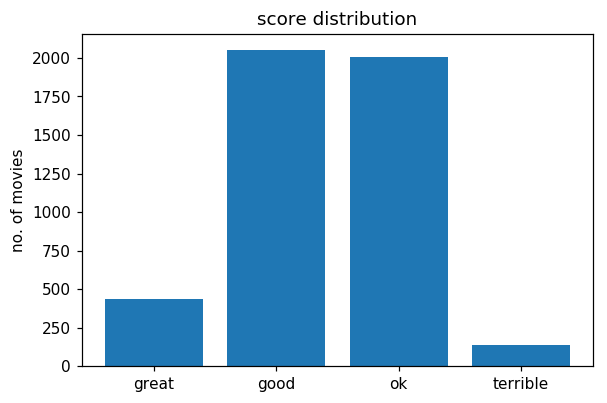

In [132]:
# put the score columns into categories
scores = list(dataset['scores'])
dataset.drop(columns='scores')
score_classes = []

for score in scores:
    if score >= 1.6 and score < 4.0:
        score_classes.append("terrible")
    elif score >= 4.0 and score < 6.5:
        score_classes.append("ok")
    elif score >= 6.5 and score < 7.8:
        score_classes.append("good")
    elif score >= 7.8 and score < 10.0:
        score_classes.append("great")
        
dataset['scores'] = score_classes

from collections import Counter
scores = Counter(list(dataset['scores']))

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(scores.keys(), scores.values())
plt.xticks([i for i in range(len(list(scores.keys())))], list(scores.keys()),)
plt.title('score distribution')
plt.ylabel('no. of movies')

In [113]:
print(dataset.columns)

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'facenumber_in_poster', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'scores'],
      dtype='object')


### ii) Split the data into independent and dependent variables

Our output (dependent) variable is the movie class, everything else is an input (independent variable). We will split the input data into these two categories.

In [114]:
print(dataset.columns)

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
"""
# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:,0] = le.fit_transform(X[:,0])
"""

# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)

print(X.shape)

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'facenumber_in_poster', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'scores'],
      dtype='object')
(4634, 27)


### iii) Apply feature scaling

Feature scaling is necessary in our case since there are massive ranges in values in some columns.

In [115]:
# Feature Scaling (necessary for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### iv) Split the dataset into training and test set with ratio 90:10

The training set will be used to train our models and the test set will be witheld for validation.

In [116]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.1, random_state = 0)

## Part 3: Model Training & Evaluation

Now that our data is preprocessed, we can start training models to predict the movie class. We will train several models and evaluate them via K-Fold (K=10) cross validation. At the end we can compare the scores and determine which is the best model.

### i) Naive Bayes

We will compare several models, the first of which is the Naive Bayes classifier, as it is the simplest model.

Through 10-fold cross validation we achieve an average accuracy of 12.21% ± 2.40, which is very low.

In [117]:
means = []
stds = []

# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

from sklearn.metrics import accuracy_score
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=NB, X=X_train, y=y_train, cv=10)
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

Accuracy is: 15.948275862068966
[[ 34  28   2 161]
 [  6  24   0  12]
 [ 12   6   0 163]
 [  0   0   0  16]]
10-fold cross validation:  12.209067644107748 ± 2.3990973610155994


### ii) K-Nearest Neighbours

We now attempy a KNN classifier using Euclidean distance and 5 neighbours, achieving an average accuracy of 58.48% ± 1.74, which is a significant improvement on the Naive Bayes.

In [118]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=KNN, X=X_train, y=y_train, cv=10)
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

Accuracy is: 61.63793103448276
[[141   7  77   0]
 [ 23  17   2   0]
 [ 52   0 128   1]
 [  3   0  13   0]]
10-fold cross validation:  58.488550938704286 ± 1.744953959979912


### iii) Support Vector Machine

Using an SVM classifier, we achieve a slight improvement on the KNN classifier, with an average accuracy of 64.15% ± 2.73.

In [119]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf', random_state = 0)
SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix, f1_score
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=SVM, X=X_train, y=y_train, cv=10)
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy is: 67.67241379310344
[[146   2  77   0]
 [ 22  18   2   0]
 [ 31   0 150   0]
 [  2   0  14   0]]


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/Ricardo/anaconda3/lib/python3.7/site-packa

10-fold cross validation:  64.15265313441652 ± 2.7281950145051823


### iv) Random Forest Classifier

Lastly of the classical methods, we fit a Random Forest Classifier, achieving a slightly better accuracy of 67.36% ± 2.60.

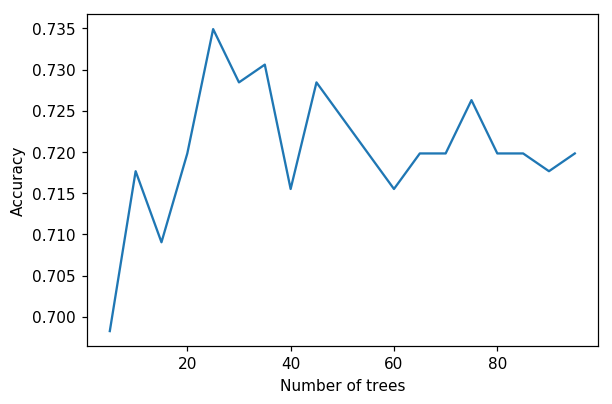

 Accuracy is: 73.49137931034483
[[178   5  42   0]
 [ 13  28   1   0]
 [ 46   0 135   0]
 [  5   0  11   0]]
10-fold cross validation:  67.36357357246818 ± 2.6014110153868937


In [120]:
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
i = 5
accs = []
while(i<100):
    RFC = RandomForestClassifier(n_estimators = i, criterion = 'entropy', random_state = 0)
    RFC.fit(X_train, y_train)

    y_pred = RFC.predict(X_test)

    a = accuracy_score(y_pred,y_test)
    accs.append(a)
    i+=5

plt.figure(dpi=110)
plt.plot([i*5 for i in range(1,20)],accs)
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.show()

import operator
index, _ = max(enumerate(accs), key=operator.itemgetter(1))

RFC = RandomForestClassifier(n_estimators = index*5 + 5, criterion = 'entropy', random_state = 0)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)

a = accuracy_score(y_pred,y_test)
print(' Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

# applying k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator=RFC, X=X_train, y=y_train, cv=10)
# compute the average accuracy and SD across 10 folds
avg = accuracies.mean() * 100
std = accuracies.std() * 100

print("10-fold cross validation: ",avg, "±", std)

means.append(avg)
stds.append(std)

### v) Neural Network

In order to use a neural network the dependent variable must be onehotencoded.

We then define the neural network, which has 3 hidden layers and train with a batch size of 16 for 200 epochs.

We achieve an accuracy of 67.9% on the test set, which is the highest of all the methods explored.

In [121]:
from sklearn.model_selection import StratifiedKFold
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
cvscores = []
for train, test in kfold.split(X_train, y_train):
    ohe = OneHotEncoder()
    y_ohe = ohe.fit_transform(y_train.reshape(-1,1)).toarray()
    # initialise the ANN
    Net = Sequential()
    # Add input layer + first hidden layer
    Net.add(Dense(units = 12, activation = 'relu'))
    # Add second & third hidden layers
    Net.add(Dense(units = 12, activation = 'relu'))
    # Add the output layer
    Net.add(Dense(units = 4, activation = 'sigmoid'))
    # Compile the Neural Network
    Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    Net.fit(X_train[train], y_ohe[train], batch_size = 64, epochs = 100, verbose=0)
    # evaluate the model
    scores = Net.evaluate(X_train[test], y_ohe[test], verbose=0)
    print("%s: %.2f%%" % (Net.metrics_names[1], scores[1]*100))
    if scores[1] * 100 > 50:
        cvscores.append(scores[1] * 100)
print("%.2f%% ± %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

means.append(np.mean(cvscores))
stds.append(np.std(cvscores))

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 62.53%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 62.20%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 63.64%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 67.22%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 43.78%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 67.87%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 68.11%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 43.86%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 65.54%


/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


accuracy: 65.54%
65.33% ± 2.19%)


### vi) Model Comparison

We will summarise the 10-fold cross validation statistics we have gathered for each model we built by plotting a bar chart of the values.

[12.209067644107748, 58.488550938704286, 64.15265313441652, 67.36357357246818, 65.33094793558121]
[2.3990973610155994, 1.744953959979912, 2.7281950145051823, 2.6014110153868937, 2.1884387808126124]


Text(0, 0.5, 'Accuracy')

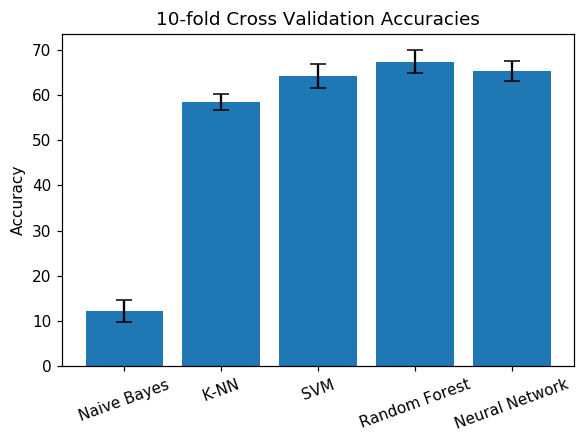

In [122]:
models = ['Naive Bayes', 'K-NN', 'SVM', 'Random Forest', 'Neural Network']

# plot the number of NaN values per column
plt.figure(dpi=110)
plt.bar(models, means, yerr=stds,align='center',ecolor='black', capsize=5)
plt.xticks([i for i in range(len(models))], models, rotation=20)
plt.title('10-fold Cross Validation Accuracies')
plt.ylabel('Accuracy')

## Part 4: Summary and Conclusions

In this analysis we have successfully built several models that predict how good a movie will be based on several inputs. We compared 5 classification models: Naïve Bayes, K Nearest Neighbours, Support Vector Machine, Random Forest Classifier and an Artificial Neural Network Classifier and found that the Random Forest Classifier with 25 trees performs the best with an average accuracy of 67.4%. 

An important conclusion that we can draw from this analysis is that sometimes the simpler model (Random Forest) is better than the complex model (Neural Net). A complex and sophisticated model will produce exceptional performance for specific tasks, making them desirable. However, this does not mean they are a magic tool that will achieve excellent performance in all use cases. Sometimes, as we have observed, simpler is better.

Some would likely argue that this accuracy is impressive; it is certainly not trivial. However, if we were building some kind of production prediction system to be used in the real world, 67.4% is simply not enough. We would really like to see accuracies of >85%. It is important to note that this analysis certainly does not show that achieving accuracies of >85% on this dataset are impossible. 